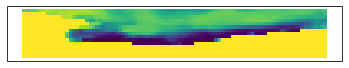

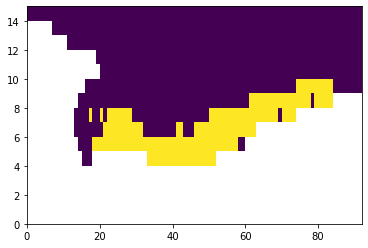

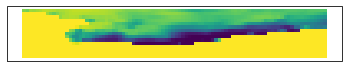

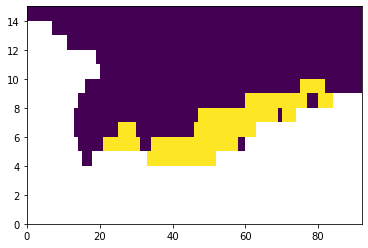

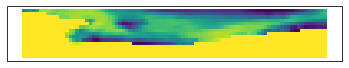

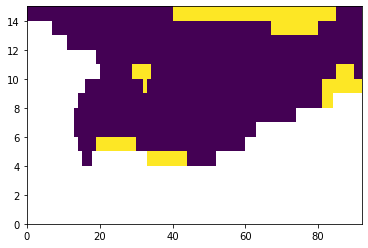

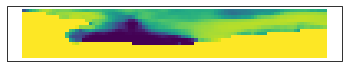

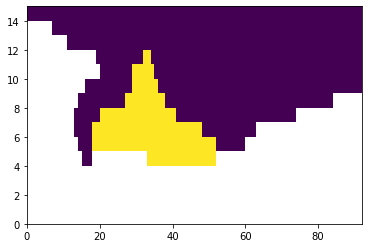

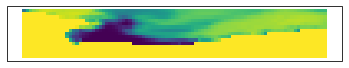

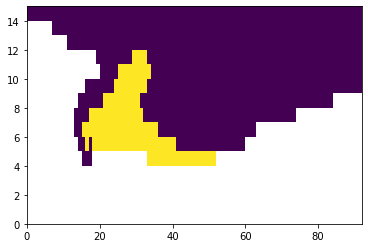

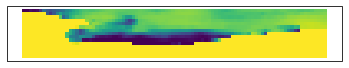

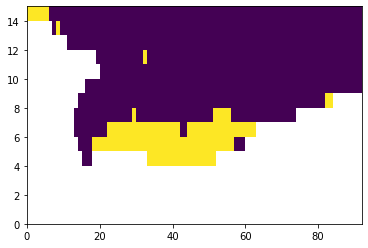

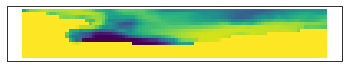

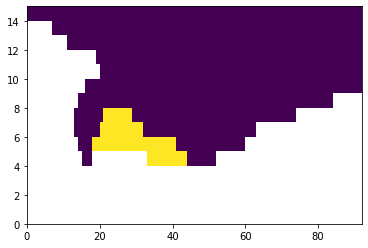

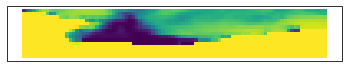

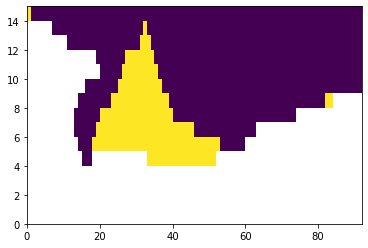

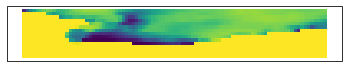

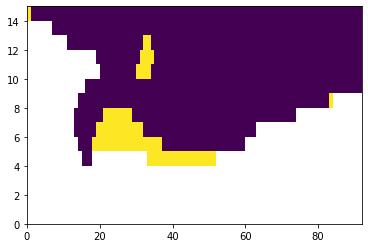

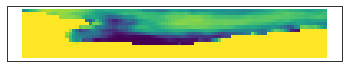

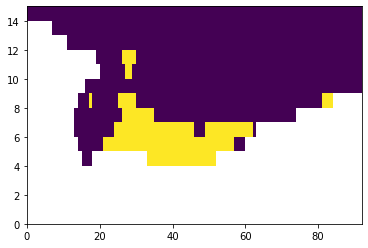

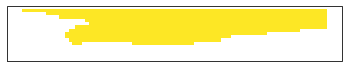

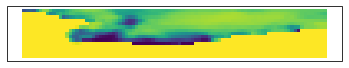

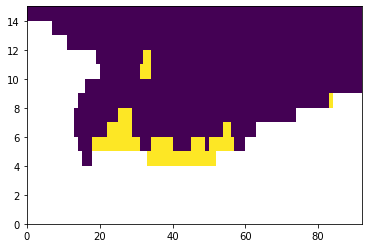

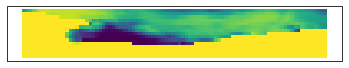

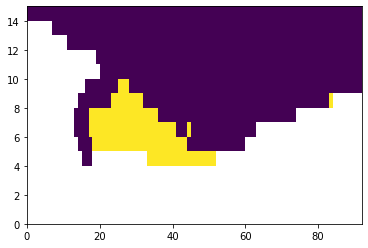

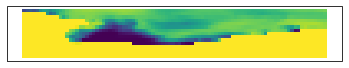

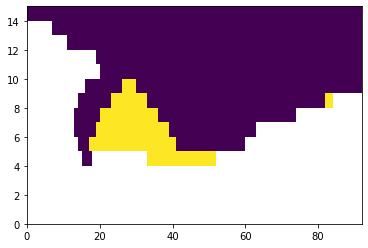

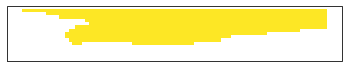

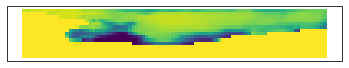

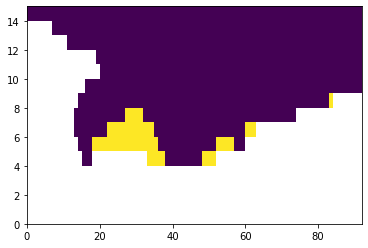

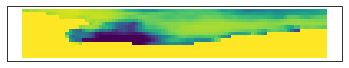

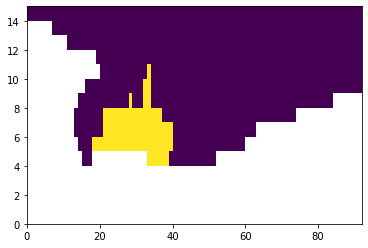

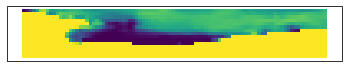

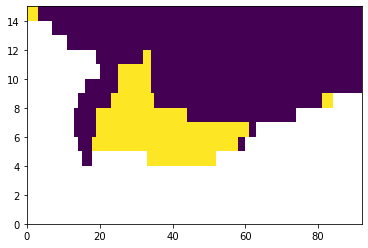

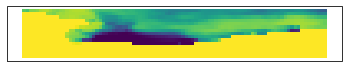

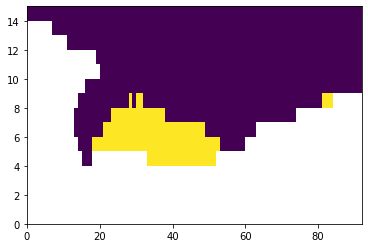

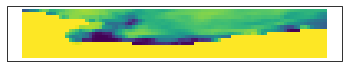

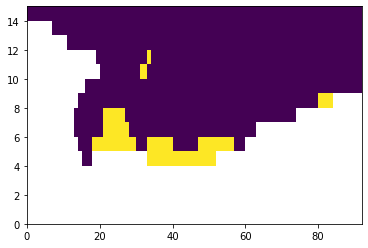

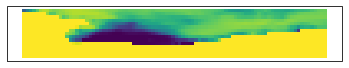

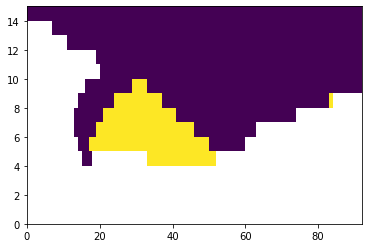

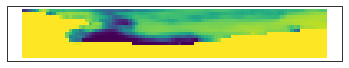

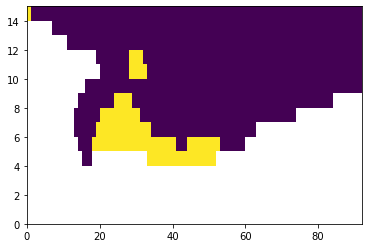

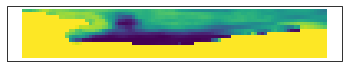

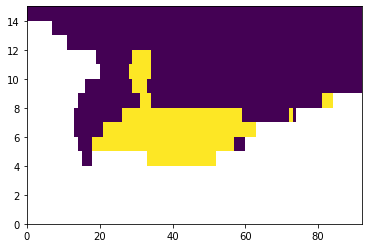

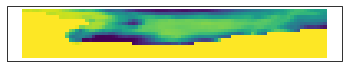

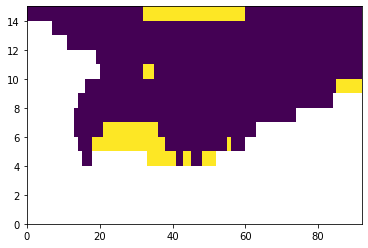

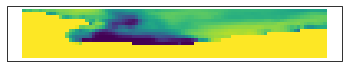

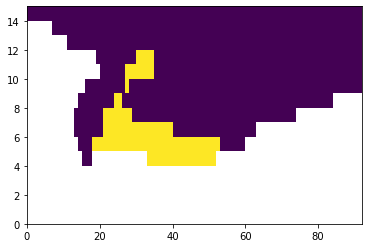

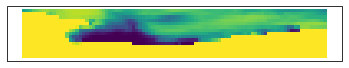

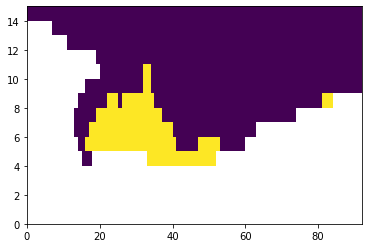

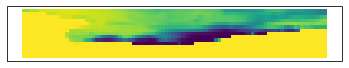

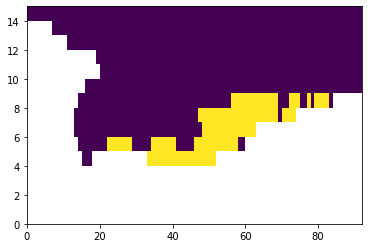

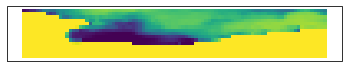

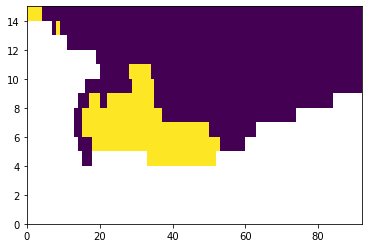

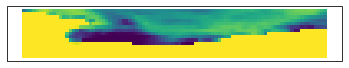

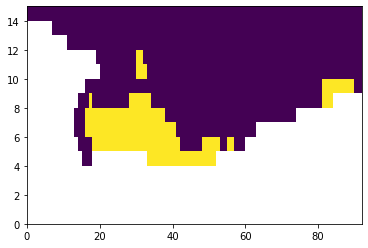

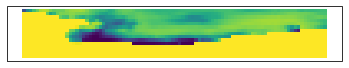

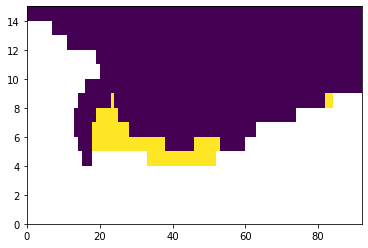

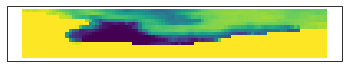

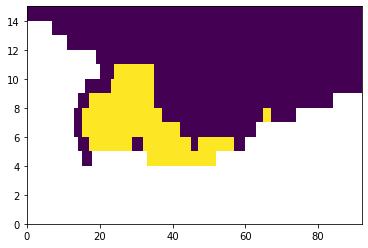

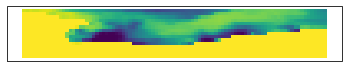

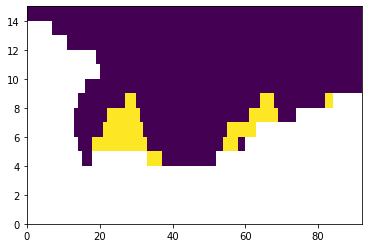

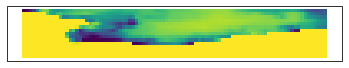

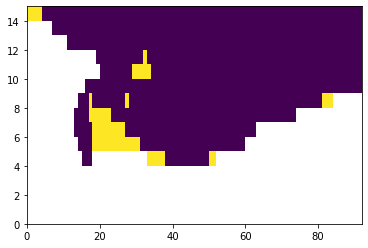

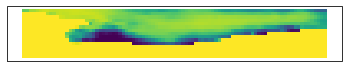

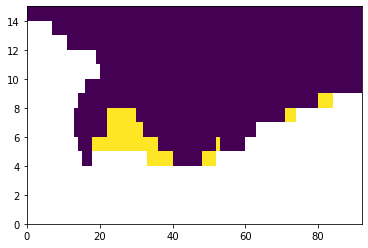

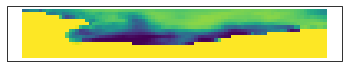

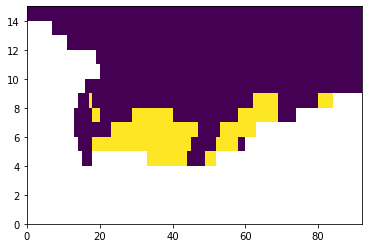

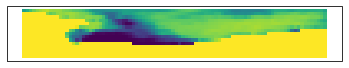

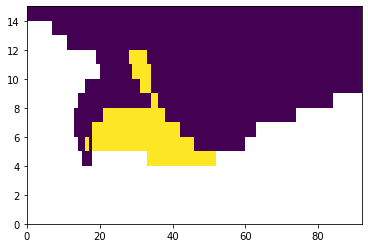

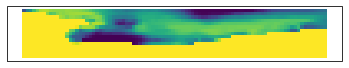

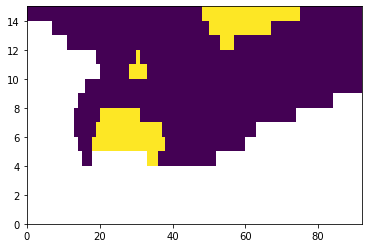

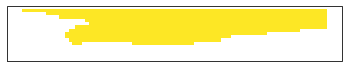

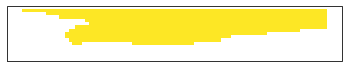

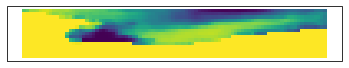

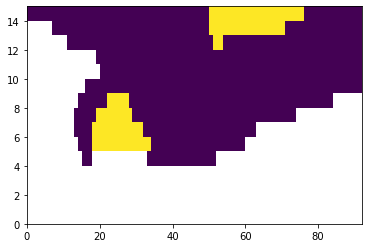

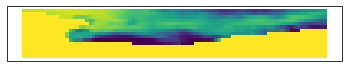

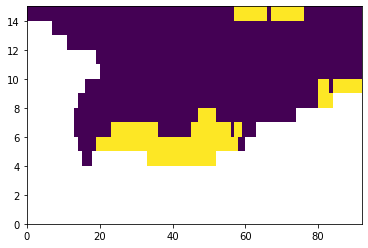

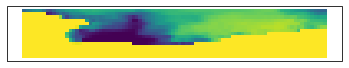

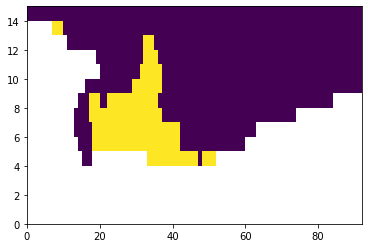

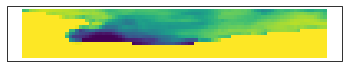

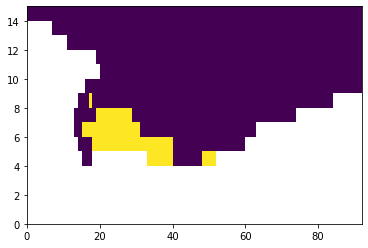

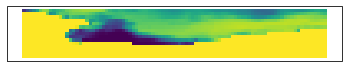

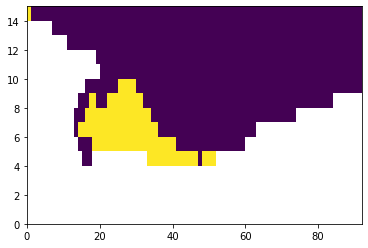

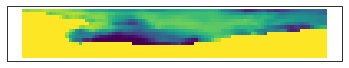

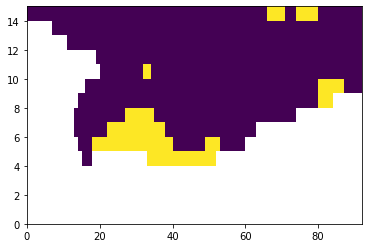

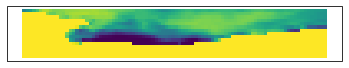

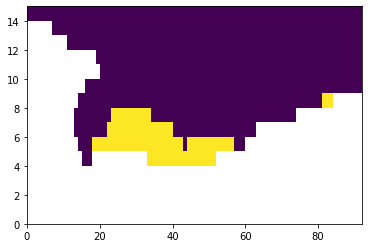

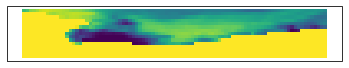

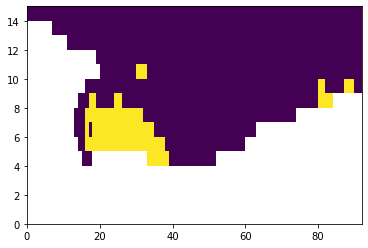

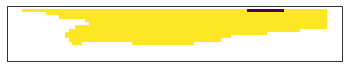

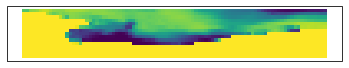

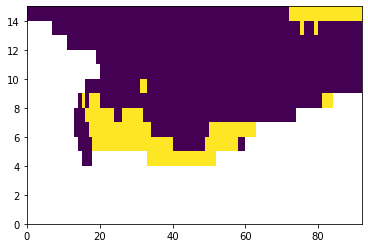

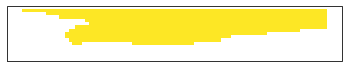

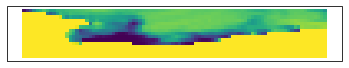

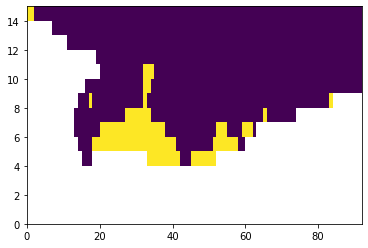

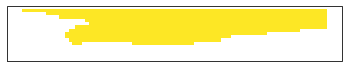

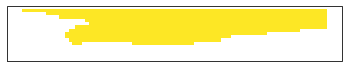

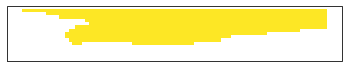

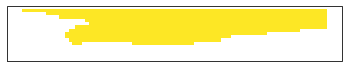

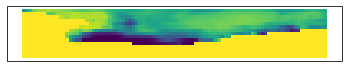

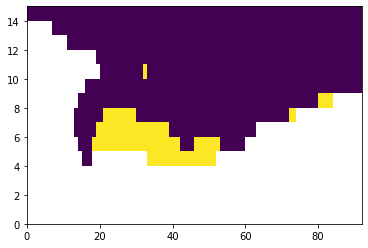

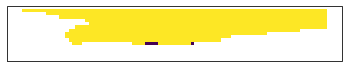

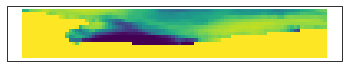

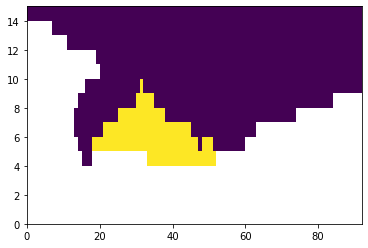

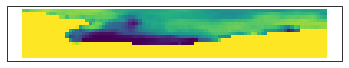

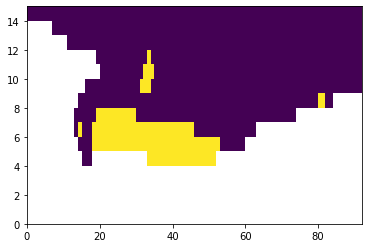

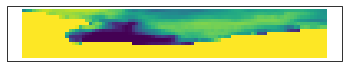

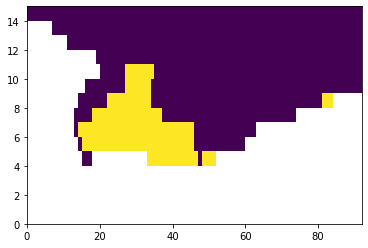

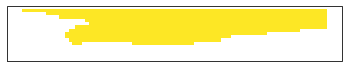

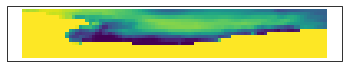

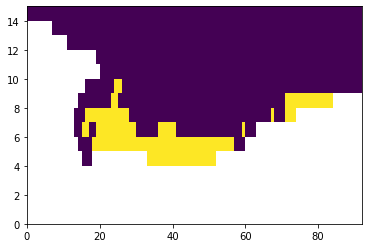

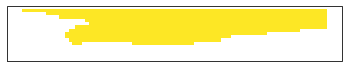

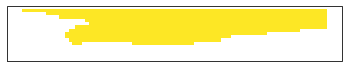

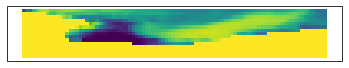

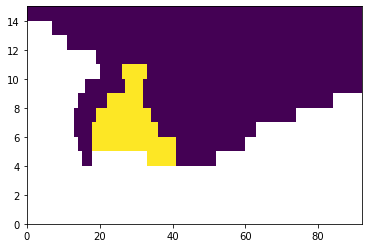

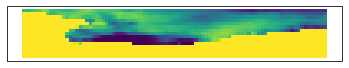

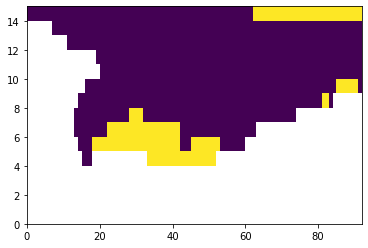

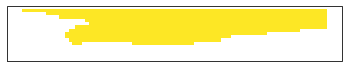

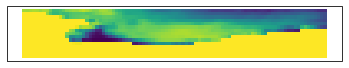

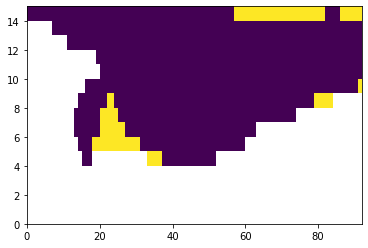

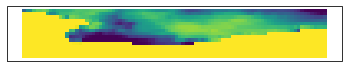

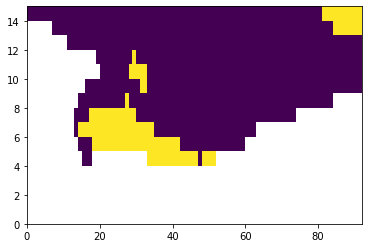

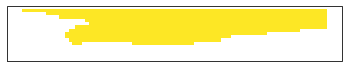

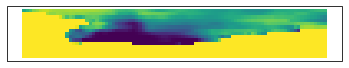

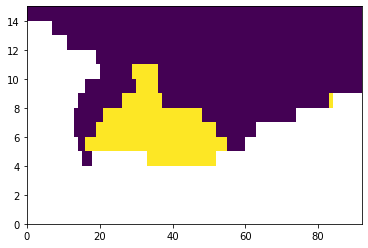

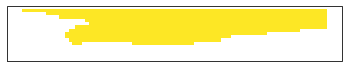

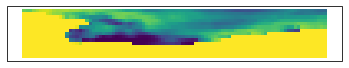

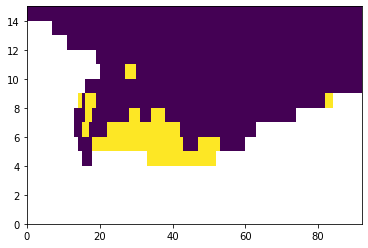

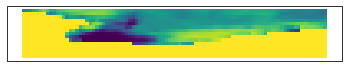

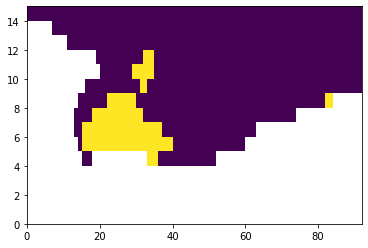

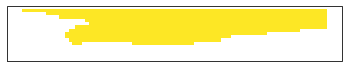

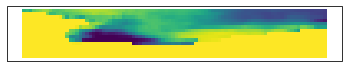

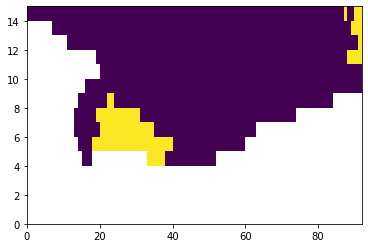

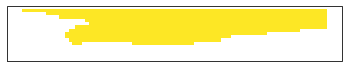

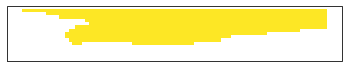

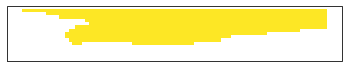

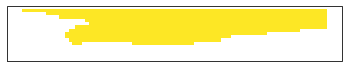

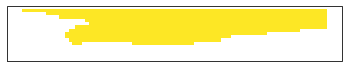

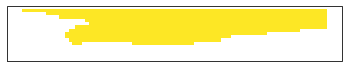

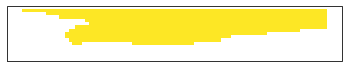

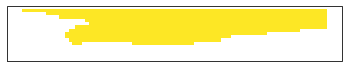

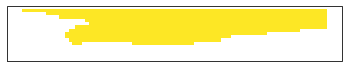

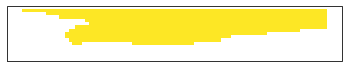

In [32]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import iris.analysis.cartography
import iris.plot as iplt
import iris.quickplot as qplt
import numpy as np
import matplotlib.ticker as mticker 
from numpy import *
from matplotlib.pyplot import *
from iris.analysis import *
from iris.coord_categorisation import * 
from iris.analysis.cartography import * 
from scipy.stats import *
from scipy.stats.mstats import *
from iris import *
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings("ignore")

fname = '/Users/alicebrindley/OneDrive - University of Exeter/siconc_SImon_GFDL-CM4_ssp585_r1i1p1f1_gr_201501-210012.nc'
cube = iris.load(fname)

siconc=cube[2] 
add_month_number(siconc, 'time', name='month_number2')
cube2 = siconc[np.where((siconc.coord('month_number2').points == 12))]
#then to average this by each year, so that you have the December-Jan for
add_season_year(cube2, 'time', name='season_year')
#then average by the season year:
cube2.aggregated_by(['season_year'], iris.analysis.MEAN)

fgname = ('/Users/alicebrindley/Dropbox/YEAR_3/Dissertation/fgco2_files/fgco2_picontrol/outfile')
fgcube = iris.load(fgname)
fgcube1=fgcube[2] 

#extract Jan and Dec to average the sea ice concentration across these mon
add_month_number(fgcube1, 'time', name='month_number1')
fgcube2 = fgcube1[np.where((fgcube1.coord('month_number1').points == 12))]
#then to average this by each year, so that you have the December-Jan for
add_season_year(fgcube2, 'time', name='season_year')
#then average by the season year:
fgcube2.aggregated_by(['season_year'], iris.analysis.MEAN)
#cube2 is therefore the data per season


# Extract the regionan of interst across teh whole cube just once at that start
west = -210 
east = -120 
south = -82 
north = -69

temporary_cube = cube2.intersection(longitude = (west, east)) 
cube2 = temporary_cube.intersection(latitude = (south, north))

fg_temporary_cube = fgcube2.intersection(longitude = (west, east)) 
fgcube2 = fg_temporary_cube.intersection(latitude = (south, north))


#Make a 3D copy of the input cube to hold teh output
polynya_location_cube = cube2.copy()
#have a variable holding just the data from this into which we can push teh processed data
polynya_location_cube_data = polynya_location_cube.data
#not just set that all to missing data (nans) so that we know if we have data in it it is real data we want not just leftovers.
polynya_location_cube_data[:] = np.nan

polynya_location_cube1 = cube2.copy()
#have a variable holding just the data from this into which we can push teh processed data
polynya_location_cube_data1 = polynya_location_cube1.data
#not just set that all to missing data (nans) so that we know if we have data in it it is real data we want not just leftovers.
polynya_location_cube_data1[:] = np.nan


#start of the loop
for i in range (0,2101-2015):
    regional_cube=cube2[i,:,:]
    ax1 = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=np.round(west + (east - west)/2.0)))
    #my_plot = iplt.contourf(regional_cube)
    #plt.gca().gridlines(draw_labels=True)
    #plt.colorbar(orientation='horizontal')
    #plt.show()

    
    latitude = -72,-72.5,-73,-73.5,-74,-74.5,-75
    grid_areas = area_weights(regional_cube)
    average_variable = regional_cube.collapsed(['latitude', 'longitude'],MEAN,weights=grid_areas)
    #print(average_variable.data)
    
    if average_variable.data >=50:
        #define siconc for polynya
        polynya_threshold=regional_cube.data
        polynya = np.where((polynya_threshold.data <=20) & (average_variable.data >=50))
        #print(polynya)
        polynya = polynya_threshold.data
        plt.pcolormesh(polynya_threshold.data,vmin=0,vmax=100)
        plt.show()
    
        #define a variable to hold the threshold number you are interested in
        polynya_threshold_value = 20.0
        #Take a copy of the seaice data that we are going to use to make a binary 'mask' showing presence of absense of polynyas as 1s and 0s
        polynya_location = polynya_threshold.data.copy()
        #set that land data in this mask to nan (Not a number) so we don;t get confused (these will show up white in a typical plot)
        polynya_location[np.where(polynya_location >= 1.0e9)] = np.nan
        #make water that has more ice than our polynia condition equal to zero.
        polynya_location[np.where((polynya_location <= 100.0) & (polynya_location > polynya_threshold_value))] = 0.0
        #make water that has less ice than our polynia condition equal to zero to make where the polynya is
        polynya_location[np.where((polynya_location > 0.0) & (polynya_location <= polynya_threshold_value))] = 1.0
        
        #Assign the data to that particular year in the 3D output array:
        polynya_location_cube_data[i,:,:] = polynya_location
        plt.pcolormesh(polynya_location, vmin=0, vmax=1)
        plt.show()

    
    else:
        regional_cube1=cube2[i,:,:]
        #define siconc for polynya
        polynya_threshold1=regional_cube1.data
        polynya = np.where(average_variable.data >=0)
        #print(polynya)
        polynya1 = polynya_threshold1.data
        #plt.pcolormesh(polynya_threshold.data,vmin=0,vmax=1)
    

        #define a variable to hold the threshold number you are interested in
        polynya_threshold_value1 = 0.0
        #Take a copy of the seaice data that we are going to use to make a binary 'mask' showing presence of absense of polynyas as 1s and 0s
        polynya_location1 = polynya_threshold1.data.copy()
        #set that land data in this mask to nan (Not a number) so we don;t get confused (these will show up white in a typical plot)
        polynya_location1[np.where(polynya_location1 >= 1.0e9)] = np.nan
        #make water that has more ice than our polynia condition equal to zero.
        polynya_location1[np.where((polynya_location1 <= 100.0) & (polynya_location1 > polynya_threshold_value1))] = 1.0
        #make water that has less ice than our polynia condition equal to zero to make where the polynya is
        polynya_location1[np.where((polynya_location1 > 0.0) & (polynya_location1 <= polynya_threshold_value1))] = 0.0
        
        #Assign the data to that particular year in the 3D output array:
        polynya_location_cube_data1[i,:,:] = polynya_location1
        
        plt.pcolormesh(polynya_location1,vmin=0,vmax=1)
        plt.show()
    
#Put th polynia data array nack in to the cube wich holds al o fteh metadata etc.
polynya_location_cube.data = polynya_location_cube_data
polynya_location_cube1.data = polynya_location_cube_data1
        

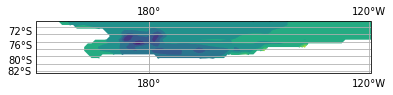

In [33]:
ax1 = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=np.round(west + (east - west)/2.0))) 
my_plot = iplt.contourf(fgcube2[0])
plt.gca().gridlines(draw_labels=True)

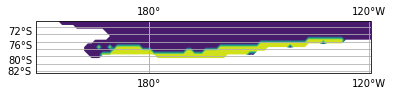

In [34]:
ax1 = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=np.round(west + (east - west)/2.0)))
my_plot = iplt.contourf(polynya_location_cube[0])
plt.gca().gridlines(draw_labels=True)

In [35]:
masked_co2_flux = polynya_location_cube * fgcube2[86,:,:]

In [36]:
masked_co2_flux1 = polynya_location_cube1 * fgcube2[86,:,:]

In [37]:
masked_co2_flux.data[np.logical_not(np.isfinite(masked_co2_flux.data))] = 0

In [38]:
masked_co2_flux1.data[np.logical_not(np.isfinite(masked_co2_flux1.data))] = 0

In [45]:
def area_avg(cube): 
    try:
        cube.coord('latitude').guess_bounds() 
    except:
        pass 
    try:
        cube.coord('longitude').guess_bounds() 
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    return cube.collapsed(['longitude', 'latitude'],iris.analysis.MEAN, weights=grid_areas)

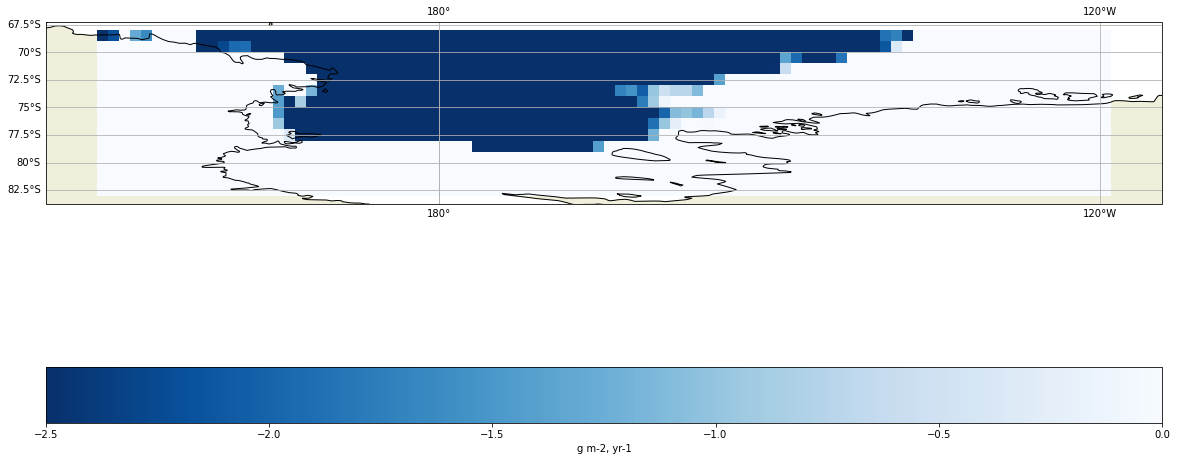

In [46]:
 # adding this so that I can add colour to the land and make sure everything make sense
import cartopy.feature as cfeature # Which time step to plot?

time_slice = 84
plt.figure(figsize=(20,20))
ax1 = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=np.round(west + (east - west)/2.0))) # 
#my_plot = iplt.pcolormesh(fgcube2[time_slice],cmap='Reds',vmin=-3.0,vmax=2.0e-8)
#my_plot = iplt.pcolormesh(polynya_location_cube[time_slice],cmap='Reds',vmin=-8.0,vmax=2.0)
my_plot = iplt.pcolormesh((masked_co2_flux1*31536000000)[time_slice],cmap='Blues_r',vmin=-2.5,vmax=0) 
plt.gca().gridlines(draw_labels=True)
# Adding shading for land and coastline
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.COASTLINE)
# adding a colourbar so I can see what the values are
plt.colorbar(orientation='horizontal', label='g m-2, yr-1')

In [47]:
def area_avg(cube): 
    try:
        cube.coord('latitude').guess_bounds() 
    except:
        pass 
    try:
        cube.coord('longitude').guess_bounds() 
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    return cube.collapsed(['longitude', 'latitude'],iris.analysis.MEAN, weights=grid_areas)

In [48]:
masked_co2_flux_timeseries = area_avg(masked_co2_flux*31536000000)

In [51]:
masked_co2_flux_timeseries1 = area_avg(masked_co2_flux1*31536000000)

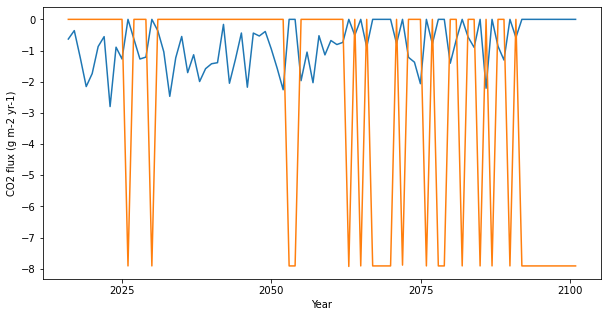

In [52]:
plt.figure(figsize=(10,5)) 
iplt.plot(masked_co2_flux_timeseries) 
iplt.plot(masked_co2_flux_timeseries1)

plt.ylabel('CO2 flux (g m-2 yr-1)') 
plt.xlabel('Year')
plt.savefig('RSP_carbon_flux')


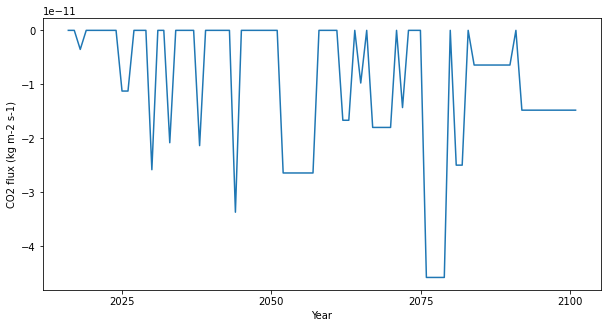

In [28]:
plt.figure(figsize=(10,5)) 
iplt.plot(masked_co2_flux_timeseries1) 

plt.ylabel('CO2 flux (kg m-2 s-1)') 
plt.xlabel('Year')
plt.savefig('RSP_carbon_flux')

